In [1]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np
import itertools as it

print(cv2.__version__)

4.9.0


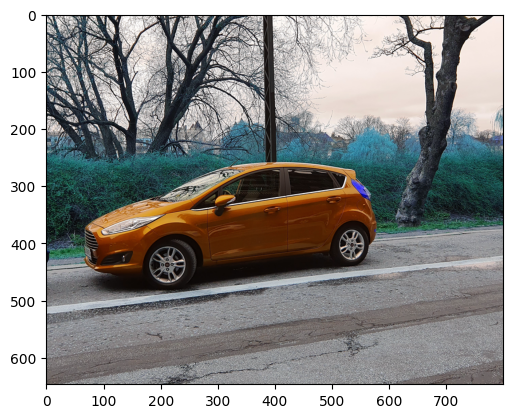

In [2]:
image = cv2.imread("images/car.png")
plt.imshow(image)

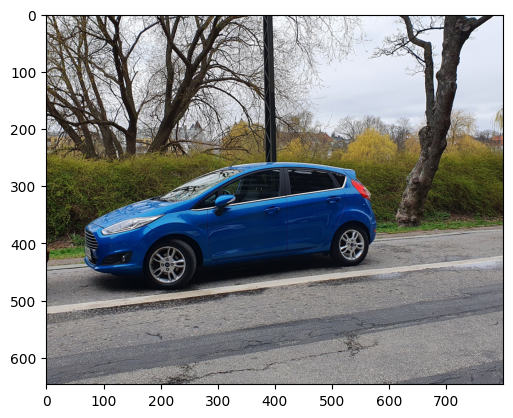

In [3]:
flipped_image= image[:,:,::-1]
plt.imshow(flipped_image)

**Pinhole Camera**
First lets make some more 3D points to “photograph”. We will use a function that generates a
number of 3D points in a recognizable shape like Figure 1

Let us define a function box3d, that generates a list of coordinates (a 3×n array) in a box shaped
like Figure 1. The box is made of points along the 12 edges and in addition, we insert a cross
through the middle. Each line has 16 points between −0.5 and 0.5.

In [4]:
def box3d(n=16):
    points = []
    N = tuple(np.linspace(-1, 1, n))
    for i, j in [(-1, -1), (-1, 1), (1, 1), (0, 0)]:
        points.extend(set(it.permutations([(i, )*n, (j, )*n, N])))
    return np.hstack(points)/2

In [17]:
#Pi that converts from homogeneous to inhomogeneous coordinates
def Pi(points_homogenous):
    points_inhomogenous = points_homogenous[:-1] / points_homogenous[-1]
    return points_inhomogenous

def PiInv(points_inhomogeneous):
    points_homogeneous=np.vstack((points_inhomogeneous, np.ones(points_inhomogeneous.shape[1])))
    return points_homogeneous
#np.hstack((world_point, 1))

Project 3D points into 2D using camera matrix and pose.

    Parameters:
    - K: Camera matrix (3x3)
    - R: Rotation matrix (3x3)
    - t: Translation vector (3x1)
    - Q: 3xN matrix representing N 3D points in columns

    Returns:
    - 2xN matrix representing the projected 2D points in columns.

In [6]:
def projectpoints(K, R, t, Q):
    
    # First creates the [R t] Matrix
    A = np.concatenate((R, t), axis=1)
    # Then, translate Q to homogenous plane => 4xn matrix by adding s=1
    B = PiInv(Q)
    # Solve the projection in homogenous plane 
    p_h = K@A@B
    # Translate back to cartesian coordinates and return (divide all by s, then remove s)
    return Pi(p_h)



(3, 60)
(3, 1)
Projected 2D Points:
(2, 60)


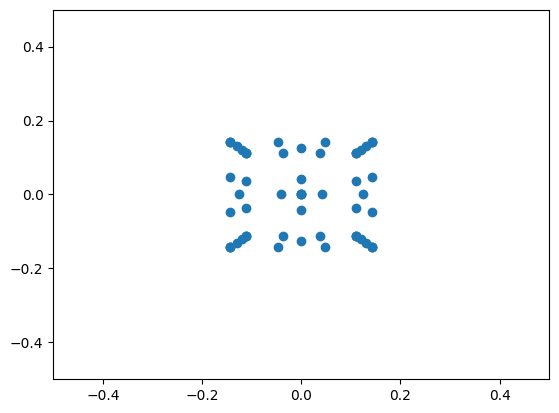

In [23]:
# Camera matrix K, rotation matrix R, translation vector t
K = np.array([[1, 0, 0],
              [0, 1, 0],
              [0, 0, 1]])

# Example rotation matrix (identity for simplicity)
R = np.eye(3)

# Example translation vector (ones for simplicity)
t_horizontal = np.array([[0,0,4]])
t = np.transpose(t_horizontal)

# Generate 3D box points using box3d function
box3d_points = box3d(4)

print(box3d_points.shape)
print(t.shape)


# Project 3D points into 2D
p = projectpoints(K, R, t, box3d_points)

print("Projected 2D Points:")
print(p.shape)
plt.scatter(p[0,:], p[1,:])
plt.xlim((-0.5, 0.5))
plt.ylim((-0.5, 0.5))
plt.show()

Using an identity matrix R and a translation vector t=[0,0,4]T, points are simply translated along the Z-axis by 4 units without any rotation. The projection onto the 2D image plane would maintain their relative positions and orientations as in the 3D space, only scaled according to the focal length (represented by the camera matrix K).

Projected 2D Points:
(2, 240)


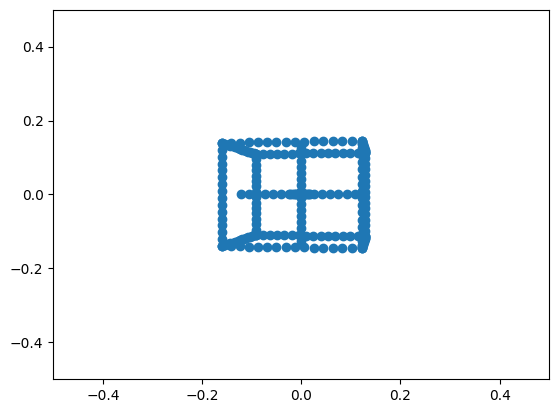

In [8]:
teta = 30
R = np.array([[np.cos(teta), 0, np.sin(teta)],
              [0, 1, 0],
              [-np.sin(teta), 0, np.cos(teta)]])

p = projectpoints(K, R, t, box3d_points)

print("Projected 2D Points:")
print(p.shape)
plt.scatter(p[0,:], p[1,:])
plt.xlim((-0.5, 0.5))
plt.ylim((-0.5, 0.5))
plt.show()

2. Translation
Effect: Translation moves the entire scene relative to the camera's position. Translating an object closer to or farther from the camera changes its apparent size in the 2D projection, due to the change in distance. This simulates the real-world phenomenon where objects appear smaller as they move away from the viewer.

3. Camera Matrix
The camera matrix affects the scale of the projection and the centering of the image.

4. Focal Length
Effect: The focal length determines the angle of view and thus how "zoomed in" the image appears. A longer focal length (telephoto lens) results in a narrower field of view and makes objects appear closer or larger in the frame. A shorter focal length (wide-angle lens) captures a wider field of view, making objects appear smaller and further apart.

5. Principal Point
Effect: The principal point is the point on the image plane where the camera's optical axis intersects it. It essentially marks the origin for the 2D coordinate system of the image. The position of the principal point affects the alignment of the projected image; if it is centered, the projection is symmetrically aligned with the optical axis. If off-center, the image may be skewed towards one edge.

  # 1.14 what does R and t do?
    # R:
    # - Scales the object while transforming to camera plane
    # - Rotate, stretch or shrink the object
    # t: moves the object in the camera plane.

A camera has focal length 1720, principal point (680, 610.0)
The camera has the rotation:
cv2.Rodrigues(np.array([-0.1, 0.1, -0.2]))[0]
and the translation:
np.array([[0.09], [0.05], [0.05]])

A 3D point in the world coordinate system has coordinates:
np.array([-0.03, 0.01, 0.59])
What is the projection of this point to the camera's image plane?

In [18]:

focal_lenght= 1720
principal_point= (680, 610.0)

K= np.array([[focal_lenght, 0, principal_point[0]],
             [0, focal_lenght, principal_point[1]],
             [0,0,1]])
R= cv2.Rodrigues(np.array([-0.1, 0.1, -0.2]))[0]
t= np.array([[0.09], [0.05], [0.05]])
Q= np.array([[-0.03], [0.01], [0.59]])
projected_points = projectpoints(K, R, t, Q)
print(projected_points)

# rotation_vector = np.array([-0.1, 0.1, -0.2])
# R = cv2.Rodrigues(rotation_vector)[0]

# print(R)

[[1023.50377104]
 [ 930.29756751]]


In [19]:
projection_matrix = np.concatenate((R, t), axis=1)
print(projection_matrix)

[[ 0.97512475  0.19303094  0.1089531   0.09      ]
 [-0.20298104  0.97512475  0.0890529   0.05      ]
 [-0.0890529  -0.1089531   0.9900499   0.05      ]]


In [20]:
world_point= np.array([-0.03, 0.01, 0.59])
Q= PiInv(Q)
Rot_point = np.dot(projection_matrix, Q)
print(Rot_point)

[[0.12695889]
 [0.11838189]
 [0.6357115 ]]


In [13]:
focal_length = 1720
principal_point= (680, 610.0)
camera_matrix = np.array([[focal_length, 0, principal_point[0]],
                           [0, focal_length, principal_point[1]],
                           [0, 0, 1]])
print(camera_matrix)

[[1.72e+03 0.00e+00 6.80e+02]
 [0.00e+00 1.72e+03 6.10e+02]
 [0.00e+00 0.00e+00 1.00e+00]]


In [14]:
hom_2d_points = np.dot(camera_matrix,Rot_point)
print(hom_2d_points)

[6.50653114e+02 5.91400859e+02 6.35711497e-01]


In [15]:
projected_points = Pi(hom_2d_points)
print(projected_points) 

[1023.50377104  930.29756751]


In [16]:
import numpy as np
import cv2

##### Projection Point step by step

# Camera parameters
focal_length = 1720
principal_point = np.array([680, 610.0])

# Rotation and translation
rotation_vector = np.array([-0.1, 0.1, -0.2])
translation_vector = np.array([[0.09], [0.05], [0.05]])
rotation_matrix = cv2.Rodrigues(rotation_vector)[0]
transformation_matrix = np.hstack([rotation_matrix, translation_vector])

# World point
world_point = np.array([-0.03, 0.01, 0.59])

# Homogeneous coordinates
world_point_homog = np.append(world_point, 1.0)

# Projection
projected_point = np.dot(transformation_matrix, world_point_homog)

# Normalize
projected_point_norm = projected_point / projected_point[2]

# Image coordinates
image_x = int(round(projected_point_norm[0] * focal_length + principal_point[0]))
image_y = int(round(projected_point_norm[1] * focal_length + principal_point[1]))

# Print result
print("Projection of the point:", (image_x, image_y))


Projection of the point: (1024, 930)
